In [19]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) already exists in sys.path


In [20]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_regression import RNNRegressor, MoodDataset, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

In [21]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, pred_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, do_bucketing=False)

Removed 24 outliers from 1002 observations. Percentage: 2.40%


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, device), n_trials=100)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-19 21:43:32,344] A new study created in memory with name: no-name-d5963d2f-c6f2-4702-b66b-c819b17a9648
[I 2025-04-19 21:43:32,850] Trial 0 finished with value: 1.3670668637842165 and parameters: {'hidden_dim': 92, 'id_embed_dim': 4, 'lr': 0.0005887234600741828, 'batch_size': 32}. Best is trial 0 with value: 1.3670668637842165.
[I 2025-04-19 21:43:33,264] Trial 1 finished with value: 3.921755213486521 and parameters: {'hidden_dim': 43, 'id_embed_dim': 11, 'lr': 0.0003839490836102752, 'batch_size': 32}. Best is trial 0 with value: 1.3670668637842165.
[I 2025-04-19 21:43:33,510] Trial 2 finished with value: 0.930006854516223 and parameters: {'hidden_dim': 95, 'id_embed_dim': 13, 'lr': 0.0022834056053016253, 'batch_size': 128}. Best is trial 2 with value: 0.930006854516223.
[I 2025-04-19 21:43:33,823] Trial 3 finished with value: 30.0354004766708 and parameters: {'hidden_dim': 78, 'id_embed_dim': 8, 'lr': 0.00021243706030724805, 'batch_size': 64}. Best is trial 2 with value: 0.9

Best hyperparams: {'hidden_dim': 71, 'id_embed_dim': 14, 'lr': 0.003106238981114269, 'batch_size': 64}


In [24]:
# Final model
model = RNNRegressor(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [28]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50)

Epoch 1: train loss = 0.2818, val loss = 0.5226
Epoch 2: train loss = 0.2787, val loss = 0.5385
Epoch 3: train loss = 0.2726, val loss = 0.5294
Epoch 4: train loss = 0.2691, val loss = 0.5297
Epoch 5: train loss = 0.2631, val loss = 0.5424
Epoch 6: train loss = 0.2601, val loss = 0.5470
Epoch 7: train loss = 0.2552, val loss = 0.5524
Epoch 8: train loss = 0.2515, val loss = 0.5683
Epoch 9: train loss = 0.2479, val loss = 0.5720
Epoch 10: train loss = 0.2411, val loss = 0.5794
Epoch 11: train loss = 0.2420, val loss = 0.5893
Epoch 12: train loss = 0.2365, val loss = 0.6017
Epoch 13: train loss = 0.2308, val loss = 0.6023
Epoch 14: train loss = 0.2286, val loss = 0.6199
Epoch 15: train loss = 0.2262, val loss = 0.6019
Epoch 16: train loss = 0.2198, val loss = 0.6088
Epoch 17: train loss = 0.2176, val loss = 0.6367
Epoch 18: train loss = 0.2131, val loss = 0.6174
Epoch 19: train loss = 0.2099, val loss = 0.6469
Epoch 20: train loss = 0.2076, val loss = 0.6277
Epoch 21: train loss = 0.2069

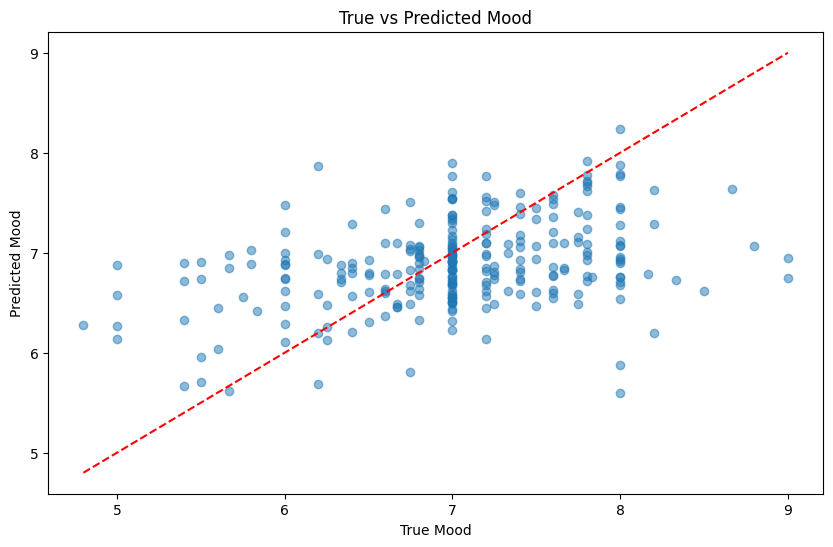

In [26]:
plot_mood_predictions(model, val_loader, device)

In [27]:
# Run predictions on test_df
test_predictions = predict(model, pred_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = pred_df.copy()
test_df_with_preds['predicted_mood'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood']])

         id  predicted_mood
0   AS14.01        7.130571
1   AS14.02        6.586953
2   AS14.03        7.018607
3   AS14.05        6.626810
4   AS14.06        6.816214
5   AS14.07        5.525919
6   AS14.08        6.664968
7   AS14.09        6.238519
8   AS14.12        6.421449
9   AS14.13        6.991408
10  AS14.14        6.863184
11  AS14.15        6.939462
12  AS14.16        6.504044
13  AS14.17        6.702740
14  AS14.19        6.821378
15  AS14.20        6.967255
16  AS14.23        7.701912
17  AS14.24        6.824320
18  AS14.25        6.503818
19  AS14.26        6.713634
20  AS14.27        7.380504
21  AS14.28        6.970297
22  AS14.29        7.346424
23  AS14.30        7.712886
24  AS14.31        6.751719
25  AS14.32        7.163476
26  AS14.33        6.418243
